In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
### Storage Setting
Ts = 1/12
c = 20
eta = 0.9

In [5]:
### Bid Ahead
# case = 'Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_ratio1.0_MIP0.1_DARTDP_Hete'
# case = 'Strategic/BidAhead/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_ratio1.0_MIP0.1_DARTDP_BAW36'
# case = 'Strategic/MarginalCost/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC10.0'
case = 'Strategic/EDH6/UC25ED6_Strategic_true_ratio1.0_Seg1_BAW0_MC20.0_1'
ESD = pd.read_csv('output/'+case+'/EDESD.csv',header=None)
ESC = pd.read_csv('output/'+case+'/EDESC.csv',header=None)
price = pd.read_csv('output/'+case+'/EDprice.csv',header=None)
ES = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/Storage_C_4hr_5GW.csv')
ESmodel = pd.read_csv('output/Strategic/ScaleMC30/Strategic/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC30.0/Strategic/storage_to_index_map.csv')

# ESmodel = pd.read_csv('output/'+case+'/Strategic/storage_to_index_map.csv')
# ESmodelTrain = pd.read_csv('models/models_profit_julia_2_100_lr001.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'output/Strategic/ScaleMC30/Strategic/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC30.0/Strategic/storage_to_index_map.csv'

In [82]:
HeteroData = []
for i in ESmodel['StorageID']:
    index = i-1
    Zone = ES['Zone'][index]
    Capacity = ES['MaxCap(MWh)'][index]
    Revenue = sum((ESD[index]-ESC[index])*price[ES['Zone'][index]])/1000
    UnitRevenue = Revenue/Capacity
    Profit = sum((ESD[index]-ESC[index])*price[ES['Zone'][index]] - Ts*c*ESD[index])/1000
    UnitProfit = Profit/Capacity
#     ModelID = ESmodel[ESmodel['StorageID']==i]['SelectedModelIndex'].item()
#     TrainProfit = ESmodelTrain['Training profit'][ModelID-1]/1000
    
    HeteroData.append({
        'Storage ID': i,
        'Zone': Zone,
        'Capacity': Capacity,
        'Revenue': Revenue,
        'UnitRevenue': UnitRevenue,
        'Profit': Profit,
        'UnitProfit': UnitProfit,
#         'ModelID': ModelID,
#         'TrainProfit': TrainProfit
    })
HeteroDatadf = pd.DataFrame(HeteroData)
Zone1ES = HeteroDatadf[HeteroDatadf['Zone']==1]
Zone2ES = HeteroDatadf[HeteroDatadf['Zone']==2]
Zone3ES = HeteroDatadf[HeteroDatadf['Zone']==3]

In [79]:
Zone2ES['UnitRevenue'].to_frame()

,UnitRevenue
5,15.672674
6,15.134779
7,14.749999
8,14.503232
9,13.945431
10,13.758829
11,13.740712
12,13.475169
13,13.327067
14,13.171915


In [6]:
HeteroData = []
for i in ESmodel['StorageID']:
    index = i-1
    Zone = ES['Zone'][index]
    Capacity = ES['MaxCap(MWh)'][index]
    Revenue = sum((ESD[index]-ESC[index])*price[ES['Zone'][index]])/1000
    Profit = sum((ESD[index]-ESC[index])*price[ES['Zone'][index]] - Ts*c*ESD[index])/1000
    UnitProfit = Profit/Capacity
    ModelID = ESmodel[ESmodel['StorageID']==i]['SelectedModelIndex'].item()
    TrainProfit = ESmodelTrain['Training profit'][ModelID-1]/1000
    
    HeteroData.append({
        'Storage ID': i,
        'Zone': Zone,
        'Capacity': Capacity,
        'Revenue': Revenue,
        'Profit': Profit,
        'UnitProfit': UnitProfit,
        'ModelID': ModelID,
        'TrainProfit': TrainProfit
    })
HeteroDatadf = pd.DataFrame(HeteroData)
Zone1ES = HeteroDatadf[HeteroDatadf['Zone']==1]
Zone2ES = HeteroDatadf[HeteroDatadf['Zone']==2]
Zone3ES = HeteroDatadf[HeteroDatadf['Zone']==3]

NameError: name 'ESmodel' is not defined

In [110]:
sum(Zone1ES['UnitProfit']*Zone1ES['Capacity'])/sum(Zone1ES['Capacity'])

12.327246665835538

In [111]:
sum(Zone2ES['UnitProfit']*Zone2ES['Capacity'])/sum(Zone2ES['Capacity'])

11.15844643659604

In [112]:
sum(Zone3ES['UnitProfit']*Zone3ES['Capacity'])/sum(Zone3ES['Capacity'])

5.368281733556005

In [3]:
### Heterogeneous Storage Profit
ESD = pd.read_csv('output/Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_ratio1.0_MIP0.1_DARTDP_Hete/EDESD.csv',header=None)
ESC = pd.read_csv('output/Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_ratio1.0_MIP0.1_DARTDP_Hete/EDESC.csv',header=None)
price = pd.read_csv('output/Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_ratio1.0_MIP0.1_DARTDP_Hete/EDprice.csv',header=None)
ES = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/Storage_C_4hr_5GW.csv')
ESmodel = pd.read_csv('output/Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_ratio1.0_MIP0.1_DARTDP_Hete/Strategic/storage_to_index_map.csv')
ESmodelTrain = pd.read_csv('models/models_profit_julia_2_100_lr001.csv')

In [4]:
HeteroData = []
for i in ESmodel['StorageID']:
    index = i-1
    Zone = ES['Zone'][index]
    Capacity = ES['MaxCap(MWh)'][index]
    Revenue = sum((ESD[index]-ESC[index])*price[ES['Zone'][index]])/1000
    Profit = sum((ESD[index]-ESC[index])*price[ES['Zone'][index]] - Ts*c*ESD[index])/1000
    UnitProfit = Profit/Capacity
    ModelID = ESmodel[ESmodel['StorageID']==i]['SelectedModelIndex'].item()
    TrainProfit = ESmodelTrain['Training profit'][ModelID-1]/1000
    
    HeteroData.append({
        'Storage ID': i,
        'Zone': Zone,
        'Capacity': Capacity,
        'Revenue': Revenue,
        'Profit': Profit,
        'UnitProfit': UnitProfit,
        'ModelID': ModelID,
        'TrainProfit': TrainProfit
    })
HeteroDatadf = pd.DataFrame(HeteroData)
Zone2ES = HeteroDatadf[HeteroDatadf['Zone']==2]

In [5]:
Zone2ES

,Storage ID,Zone,Capacity,Revenue,Profit,UnitProfit,ModelID,TrainProfit
5,41,2,20.0,233.676294,198.349622,9.917481,1,22.380176
6,42,2,1000.0,14239.573568,11920.443974,11.920444,2,22.092361
7,43,2,35.0,548.708013,457.546728,13.072764,3,22.886560
8,44,2,350.0,4708.692592,4015.539836,11.472971,4,21.938970
9,45,2,20.0,262.186065,223.944130,11.197207,5,22.573074
10,46,2,100.0,1029.676799,899.265741,8.992657,6,21.307698
11,47,2,100.0,1314.384582,1130.912843,11.309128,7,21.788353
12,48,2,605.0,6532.737890,5618.141391,9.286184,8,21.953104
13,49,2,90.0,1073.587645,928.901031,10.321123,9,22.886158
14,50,2,60.0,843.382810,715.835700,11.930595,10,22.350219


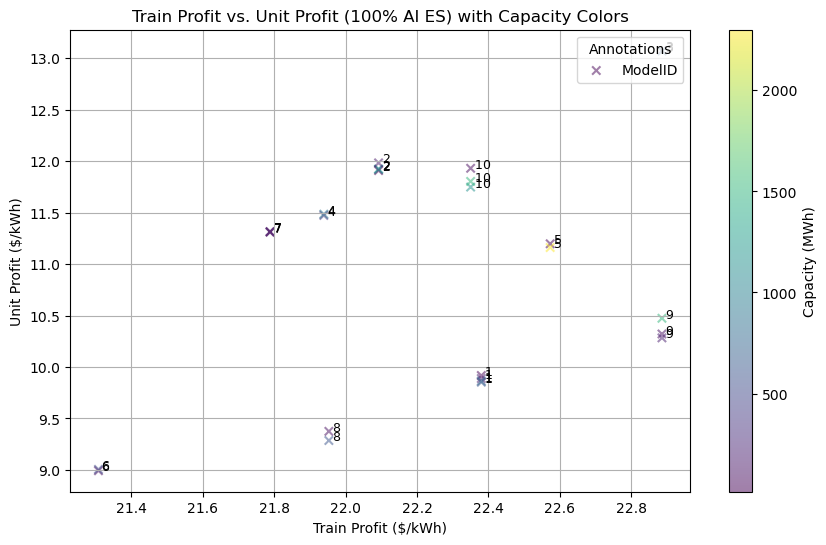

In [6]:
plt.figure(figsize=(10, 6))
# Using capacity as the color variable
scatter = plt.scatter(Zone2ES['TrainProfit'], Zone2ES['UnitProfit'], marker='x', c=Zone2ES['Capacity'], cmap='viridis', alpha=0.5)

# Adding a color bar to indicate the capacity values
cbar = plt.colorbar(scatter)
cbar.set_label('Capacity (MWh)')

# Annotating each point with its capacity number (without "MWh" unit in the annotation)
for i in range(len(Zone2ES)):
    plt.text(Zone2ES['TrainProfit'].iloc[i], Zone2ES['UnitProfit'].iloc[i], f" {Zone2ES['ModelID'].iloc[i]}", fontsize=9)

# Adding a legend to explain the annotations
plt.legend([scatter], ['ModelID'], loc="upper right", title="Annotations")

plt.title('Train Profit vs. Unit Profit (100% AI ES) with Capacity Colors')

plt.xlabel('Train Profit ($/kWh)')
plt.ylabel('Unit Profit ($/kWh)')
plt.grid(True)
plt.show()

In [ ]:
### Price Analysis
# price = pd.read_csv('output/Strategic/Scale/UC25ED1_Strategic_true_Seg5_Load1.0_Fuel1.2_Error0.25_ratio0.5_MIP0.1_DARTDP/EDprice.csv',header=None)
# df = pd.concat([price.mean()*12, (price*12).std()], axis=1)
# df.T

In [13]:
### Emission
ThermalGen = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/ThermalGen_Full_C.csv')
case = 'Strategic/MC20/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC20.0'
EDGen = pd.read_csv('output/'+case+'/EDGen.csv',header=None)

In [14]:
def distribute_output_across_segments(interval_output, thermalgen_row):
    """
    Distribute a single interval's output across the generator's operational segments.

    :param interval_output: The total output for the generator in a 5-minute interval.
    :param thermalgen_row: A pandas Series containing the generator's segment data.
    :return: A list where each element represents the output allocated to a segment.
    """
    # Initialize variables
    segment_outputs = []  # Stores the output allocated to each segment
    remaining_output = interval_output
    
    # Base segment output
    if remaining_output > 0:
        base_output = min(remaining_output, thermalgen_row['IOMinCap(MW)'])
        segment_outputs.append(base_output)
        remaining_output -= base_output
    else:
        segment_outputs.append(0)

    # Incremental segments
    for i in range(2, 7):  # Assuming up to 6 segments
        inc_cap_key = f'IncCap{i}(MW)'
        if inc_cap_key in thermalgen_row.index and thermalgen_row[inc_cap_key] > 0:
            if remaining_output > 0:
                segment_capacity = thermalgen_row[inc_cap_key]
                segment_output = min(remaining_output, segment_capacity)
                segment_outputs.append(segment_output)
                remaining_output -= segment_output
            else:
                segment_outputs.append(0)
        else:
            break  # No more segments defined

    # If there are less than 6 segments, fill the remaining with 0s
    while len(segment_outputs) < 6:
        segment_outputs.append(0)

    return segment_outputs

In [15]:
# Initialize a dictionary to store the interval outputs for each segment
interval_segment_outputs = {gen_id: [] for gen_id in EDGen.columns}

for gen_id in EDGen.columns:
    thermalgen_row = ThermalGen.loc[gen_id]  # Adjust this line based on how you match generators
    
    for interval_output in EDGen[gen_id]:
        segment_outputs = distribute_output_across_segments(interval_output, thermalgen_row)
        interval_segment_outputs[gen_id].append(segment_outputs)

In [16]:
# Placeholder for the aggregated hourly segment outputs
hourly_segment_outputs = {gen_id: pd.DataFrame(columns=[f'Segment{i}' for i in range(1, 7)]) for gen_id in EDGen.columns}

for gen_id, outputs in interval_segment_outputs.items():
    # Convert list of outputs to DataFrame for easier manipulation
    outputs_df = pd.DataFrame(outputs, columns=[f'Segment{i}' for i in range(1, 7)])
    
    # Aggregate to hourly by summing every 12 rows (12 intervals per hour)
    hourly_data = outputs_df.groupby(outputs_df.index // 12).sum()
    
    hourly_segment_outputs[gen_id] = hourly_data

In [17]:
def map_emission_factor(fuel_name):
    if fuel_name.startswith('Coal'):
        return 95.92
    elif fuel_name.startswith('NG'):
        return 52.91
    elif fuel_name.startswith('Oil'):
        return 74.14
    elif fuel_name == 'Petroleum Coke':
        return 102.41
    elif fuel_name == 'Geothermal' or fuel_name == 'Uranium':
        return 0
    elif fuel_name == 'Waste_Heat':
        return 66.33
    elif fuel_name in ['Bio_Landfill_Gas', 'Bio_Other']:
        return 52.07
    elif fuel_name == 'Bio_Wood':
        return 93.80
    elif fuel_name == 'Bio_Blk_Liquor':
        return 73.84
    elif fuel_name == 'Bio_Solid_Waste':
        return 90.70
    elif fuel_name == 'Bio_Agri_Res':
        return 118.17
    elif fuel_name == 'DefaultFuel':
        return 52.91
    else:
        return None  # Or a default value if you have one for unknown types

# Apply the function to create a new column
ThermalGen['Emission Factor'] = ThermalGen['Fuel Name'].apply(map_emission_factor)

# Check if there's any fuel type that did not get an emission factor (None values)
missing_emission_factors = ThermalGen[ThermalGen['Emission Factor'].isnull()]
if not missing_emission_factors.empty:
    print("Missing emission factors for:", missing_emission_factors['Fuel Name'].unique())
else:
    print("All fuel types have assigned emission factors.")

All fuel types have assigned emission factors.


In [18]:
# Initialize a DataFrame to store hourly total emissions for all generators
hourly_total_emissions = pd.DataFrame(index=hourly_segment_outputs[0].index)

for gen_id in hourly_segment_outputs.keys():
    thermalgen_row = ThermalGen.loc[gen_id]
    hourly_data = hourly_segment_outputs[gen_id]
    emission_factor = thermalgen_row['Emission Factor']
    
    # Initialize a Series to store total hourly fuel consumption for this generator
    hourly_fuel_consumption = pd.Series(0, index=hourly_data.index)

    # Calculate fuel consumption for each segment
    for i in range(1, 7):  # Assuming up to 6 segments
        segment_key = f'Segment{i}'
        if i == 1:
            # Base segment calculation
            base_fuel = (hourly_data[segment_key] * thermalgen_row['MinInput(MMBTu)'] / thermalgen_row['IOMinCap(MW)']).fillna(0) / 12
            hourly_fuel_consumption += base_fuel
        else:
            # Incremental segments
            hr_key = f'IncHR{i}(MMBTu/MWh)'
            if hr_key in thermalgen_row.index and thermalgen_row[hr_key] > 0:
                incremental_fuel = (hourly_data[segment_key] * thermalgen_row[hr_key]).fillna(0) / 12
                hourly_fuel_consumption += incremental_fuel

    # Calculate total hourly emissions for this generator
    hourly_emissions = hourly_fuel_consumption * emission_factor
    hourly_total_emissions[gen_id] = hourly_emissions

hourly_total_emissions.head()

/var/folders/f2/rxpbf6rd2wjbpqry4k3rs6fr0000gn/T/ipykernel_73228/249470520.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hourly_total_emissions[gen_id] = hourly_emissions


,0,1,2,3,4,5,6,7,8,9,...,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301
0,1199.047132,1380.399652,1380.399652,1380.399652,1380.399652,1380.399652,1380.399652,7421.95366,13631.926,894.252263,...,86906.077115,86906.077115,8336.4996,6404.91423,81378.209627,81378.209627,8336.4996,5937.232158,8336.4996,11681.4984
1,1199.047132,1380.399652,1380.399652,1380.399652,1380.399652,1380.399652,1380.399652,7421.95366,13631.926,894.252263,...,86906.077115,86906.077115,8336.4996,6404.91423,81378.209627,81378.209627,8336.4996,5937.232158,8336.4996,11681.4984
2,1199.047132,1380.399652,1380.399652,1380.399652,1380.399652,1380.399652,1380.399652,7421.95366,13631.926,894.252263,...,86906.077115,86906.077115,8336.4996,6404.91423,81378.209627,81378.209627,8336.4996,5937.232158,8336.4996,11681.4984
3,1199.047132,1380.399652,1380.399652,1380.399652,1380.399652,1380.399652,1380.399652,7421.95366,13631.926,894.252263,...,86906.077115,86906.077115,8336.4996,6404.91423,81378.209627,81378.209627,8336.4996,5937.232158,8336.4996,11681.4984
4,1199.047132,1380.399652,1380.399652,1380.399652,1380.399652,1380.399652,1380.399652,7421.95366,13631.926,894.252263,...,86906.077115,86906.077115,8336.4996,6404.91423,81378.209627,81378.209627,8336.4996,5937.232158,8336.4996,11681.4984


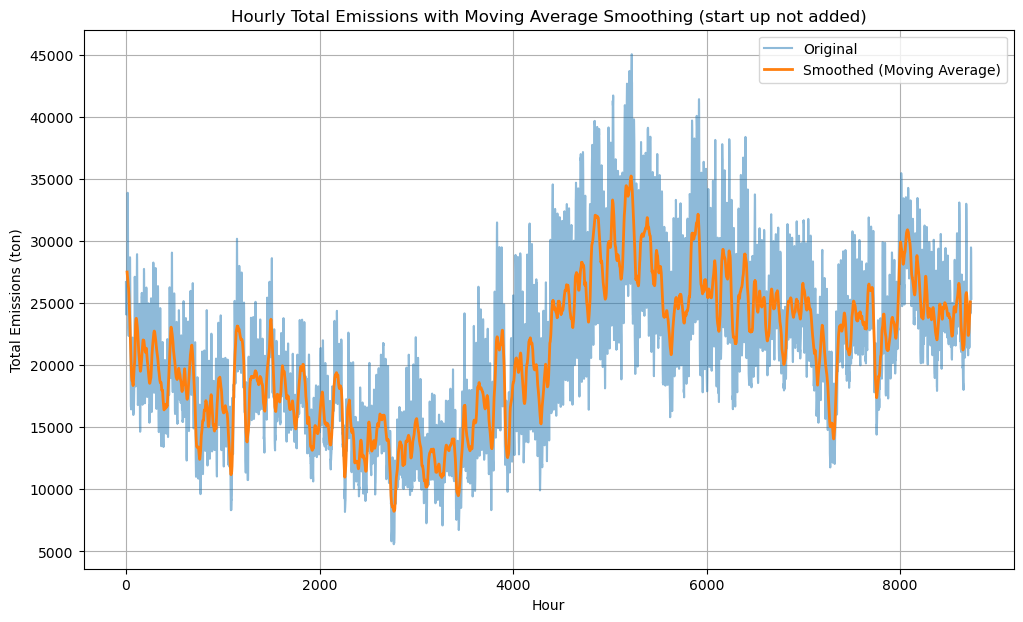

In [19]:
# Sum across rows and plot
row_sums = hourly_total_emissions.sum(axis=1)/1000
window_size = 24  # For example, for hourly data, a 24-hour (daily) moving average
smoothed_sums = row_sums.rolling(window=window_size, center=True).mean()

plt.figure(figsize=(12, 7))
plt.plot(row_sums.index, row_sums.values, label='Original', alpha=0.5)  # Making the original line semi-transparent
plt.plot(smoothed_sums.index, smoothed_sums.values, label='Smoothed (Moving Average)', linewidth=2)

plt.title('Hourly Total Emissions with Moving Average Smoothing (start up not added)')
plt.xlabel('Hour')  # Adjust label if your index has a different meaning
plt.ylabel('Total Emissions (ton)')
plt.legend()
plt.grid(True)
plt.show()